### Multi-level models (Varying intercept and slope)
***
This is an example on how to fit an MLM model using python and `pymer4` package. Pymer4 is a python version of the famous `lme4` package in R, and its documentation is available at: https://eshinjolly.com/pymer4/


In [1]:
#pip install pymer4

Load packages

In [2]:
import warnings

import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import libpysal as ps
from libpysal.weights import Queen
from esda.moran import Moran

from pymer4.models import Lmer

We will be using the same voting data to demostrate the MLM. 

In [3]:
voting = pd.read_csv('https://raw.github.com/Ziqi-Li/gis5122/master/data/voting_2020_with_gov.csv')

#voting[['median_income']] = voting[['median_income']]/10000

In [4]:
shp = gpd.read_file("https://raw.github.com/Ziqi-Li/gis5122/master/data/us_counties.geojson")

In [5]:
#Merge the shapefile with the voting data by the common county_id
shp_voting = shp.merge(voting, on ="county_id")

#Dissolve the counties to obtain boundary of states, used for mapping
state = shp_voting.dissolve(by='STATEFP')

### Fit an MLM model (Varying intercept and slope by state)

In [6]:
warnings.filterwarnings('ignore')

model_all_states = Lmer('new_pct_dem ~ 1 + pct_bach + (1 + pct_bach | state)', data=shp_voting)

model_all_states.fit()

Model failed to converge with max|grad| = 0.129117 (tol = 0.002, component 1) 

Linear mixed model fit by REML [’lmerMod’]
Formula: new_pct_dem~1+pct_bach+(1+pct_bach|state)

Family: gaussian	 Inference: parametric

Number of observations: 3102	 Groups: {'state': 47.0}

Log-likelihood: -12037.964 	 AIC: 24087.929

Random effects:

                 Name      Var     Std
state     (Intercept)  119.701  10.941
state        pct_bach    0.076   0.276
Residual               128.334  11.328

               IV1       IV2   Corr
state  (Intercept)  pct_bach -0.641

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),18.327,14.825,21.830,1.787,42.611,10.256,0.0,***
pct_bach,0.791,0.693,0.888,0.050,42.962,15.852,0.0,***


Model AIC

In [7]:
model_all_states.AIC

24087.928602917116

Marginal R2: describes the proportion of variance explained by the fixed factor(s) alone

Conditional R2: describes the proportion of variance explained by both the fixed and random factors

From Nakagawa and Schielzeth (2012) [Link](https://besjournals.onlinelibrary.wiley.com/doi/10.1111/j.2041-210x.2012.00261.x)

In [8]:
def r_square(model):
    var_a = np.sum(model.ranef_var.Var[:-1]) #Sum of variances from random effects
    var_e = model_all_states.ranef_var.Var[-1] #Error variance 
    var_f = np.sum(model.design_matrix*model.coefs.Estimate,axis=1).var() #Sum of variances from fixed effects
    
    marginal = var_f/(var_f+var_a+var_e)
    
    conditional = (var_f+var_a)/(var_f+var_a+var_e)
    
    print("marginal R2:",marginal)
    print("conditional R2:",conditional)
    return

In [9]:
r_square(model_all_states)

marginal R2: 0.18633369427772392
conditional R2: 0.5791354545442352


We can also see the distribution of the random effects, they are supposed to drawn from a multi-variate normal distribution with varaince of 119.701 for intercept, 0.076 for pct_bach and a correlation of -0.641. 

array([[<Axes: title={'center': 'X.Intercept.'}>,
        <Axes: title={'center': 'pct_bach'}>]], dtype=object)

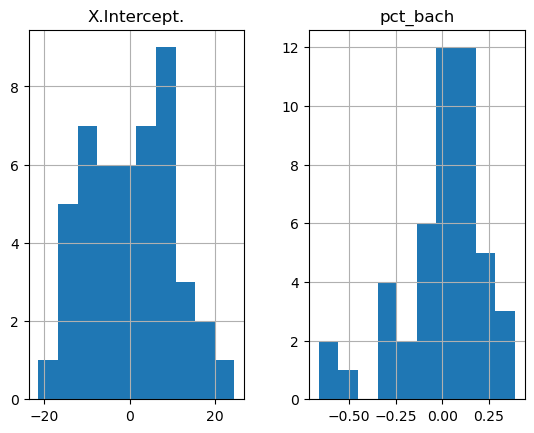

In [10]:
model_all_states.ranef.hist()

Text(0, 0.5, 'Random effect of pct_bach')

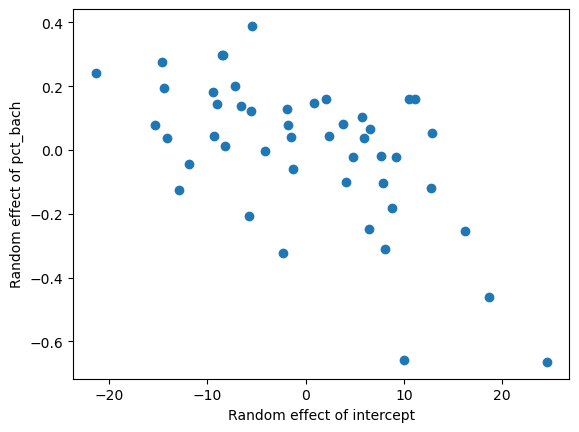

In [11]:
plt.scatter(model_all_states.ranef.iloc[:,0], model_all_states.ranef.iloc[:,1])
plt.xlabel("Random effect of intercept")
plt.ylabel("Random effect of pct_bach")

A negative correlation indicates that when the intercept is larger, the slope is (smaller) flatter across the states.


If we map the random effects to show how each state deviates from the overall effect, the maps would be as follows:

Text(0.5, 1.0, 'Varying intercept')

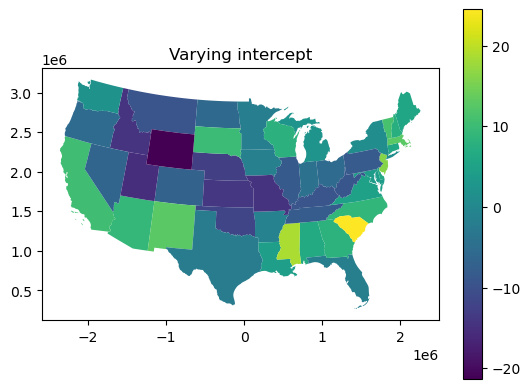

In [12]:
state.plot(model_all_states.ranef.iloc[:,0].values,legend=True)
plt.title("Varying intercept")

Text(0.5, 1.0, 'Varying slope of pct_bach')

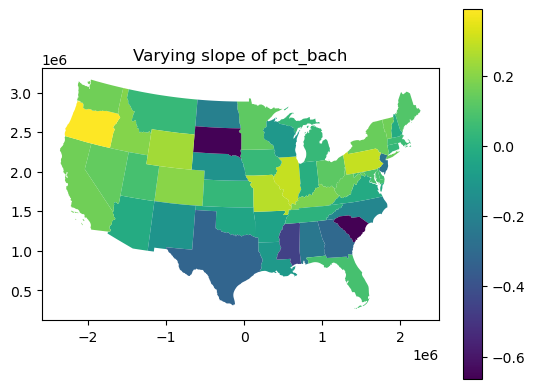

In [13]:
state.plot(model_all_states.ranef.iloc[:,1].values,legend=True)
plt.title("Varying slope of pct_bach")

The random effects, again, show us the deviations from the fixed effects.
You could also add the fixed effect estimate to get the map of the total effect (fixed + random).
That is, to add 18.327 for the intercept map and 0.791 for the bach map.

### Confidence intervals of the effects (fixed and random)

In [14]:
model_all_states.confint(method='boot', level=0.95, nsim=1000)

Computing bootstrap confidence intervals ...


91 warning(s): Model failed to converge with max|grad| = 0.00200431 (tol = 0.002, component 1) (and others)




,2.5 %,97.5 %
sd_(Intercept)|state,8.013204,13.574314
cor_pct_bach.(Intercept)|state,-0.823212,-0.339756
sd_pct_bach|state,0.195109,0.358206
sigma,11.054547,11.600071
(Intercept),14.861046,22.092519
pct_bach,0.681197,0.886333


All of them are statsitically significant that having 95% CI excludes zero. 

However, if any confidence interval includes zero, then it is not statsitically significant.

If a random effect is not significant, it means that there is no variability across the groups.

If a fixed effect is not significant, it means that it has no global effect to the dependent variable.